In [1]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the knee is fully lifted and the arm is raised high
def is_full_knee_lift_and_arm_high(knee, hip, shoulder, elbow, wrist):
    """
    Determines if the knee is fully lifted and the arm is raised high by analyzing the
    relative positions of the knee to the hip and wrist to the shoulder.
    """
    knee_x, knee_y = knee
    hip_x, hip_y = hip
    shoulder_x, shoulder_y = shoulder
    elbow_x, elbow_y = elbow
    wrist_x, wrist_y = wrist

    # Knee is considered lifted if it's higher than the hip
    knee_lifted = knee_y < hip_y

    # Arm is considered raised if the wrist is higher than the shoulder and elbow
    arm_high = wrist_y < shoulder_y and wrist_y < elbow_y

    return knee_lifted and arm_high

# Paths for the stage 3 videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage3/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage3/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for knee lift and arm height analysis
                left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
                left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                                 landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
                left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x,
                              landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y]
                left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x,
                              landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y]

                right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                             landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                                  landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
                right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x,
                               landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y]
                right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x,
                               landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y]

                # Check if knee is lifted and arm is high for both sides
                left_takeoff = is_full_knee_lift_and_arm_high(left_knee, left_hip, left_shoulder, left_elbow, left_wrist)
                right_takeoff = is_full_knee_lift_and_arm_high(right_knee, right_hip, right_shoulder, right_elbow, right_wrist)

                # Store data for this frame
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "left_takeoff": left_takeoff,
                    "right_takeoff": right_takeoff,
                    "left_knee": left_knee,
                    "left_hip": left_hip,
                    "left_shoulder": left_shoulder,
                    "left_elbow": left_elbow,
                    "left_wrist": left_wrist,
                    "right_knee": right_knee,
                    "right_hip": right_hip,
                    "right_shoulder": right_shoulder,
                    "right_elbow": right_elbow,
                    "right_wrist": right_wrist
                })

        # Release the video
        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Knee lift and arm height analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737665237.315508 11090681 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737665237.376650 11090994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737665237.388010 11090994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737665237.402132 11091003 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Knee lift and arm height analysis complete! JSON files saved in 'keypoints' folder.


In [3]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for knee lift and arm height analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage3/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract knee lift and arm high indicators across all frames
        knee_arm_data = [
            [int(frame["left_takeoff"]), int(frame["right_takeoff"])]
            for frame in data
        ]
        sequences.append(knee_arm_data)

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

        labels.append(label)

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 15 sequences with labels.


In [4]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 75


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Ensure correct shape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 2))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 57, Validation samples: 18


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.6451 - mae: 0.6562 - val_loss: 0.6373 - val_mae: 0.7206
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.5962 - mae: 0.6921 - val_loss: 0.3611 - val_mae: 0.5693
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.3243 - mae: 0.5233 - val_loss: 0.1585 - val_mae: 0.3292
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2837 - mae: 0.4572 - val_loss: 0.1840 - val_mae: 0.3953
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.2520 - mae: 0.4644 - val_loss: 0.2079 - val_mae: 0.4369
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2049 - mae: 0.4312 - val_loss: 0.2055 - val_mae: 0.4394
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2382 - mae: 0.4592 - val_loss: 0.1719 - val_mae: 0.3613
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1994 - mae: 0.3828 - val_loss: 0.1760 - val_mae: 0.3709
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1960 - mae:

In [8]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.1832, Validation MAE: 0.2426


In [9]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Predicted: -0.00, Actual: 0.00
Predicted: 0.91, Actual: 1.00
Predicted: 0.94, Actual: 1.00
Predicted: -0.01, Actual: 0.00
Predicted: 0.93, Actual: 1.00
Predicted: 0.96, Actual: 1.00
Predicted: -0.03, Actual: 0.00
Predicted: 0.08, Actual: 1.00
Predicted: 0.94, Actual: 1.00
Predicted: 0.94, Actual: 1.00
Predicted: 1.00, Actual: 1.00
Predicted: 0.06, Actual: 1.00
Predicted: -0.05, Actual: 0.00
Predicted: 0.94, Actual: 1.00
Predicted: 0.14, Actual: 1.00
Predicted: 0.75, Actual: 1.00
Predicted: 0.14, Actual: 1.00
Predicted: 1.01, Actual: 1.00


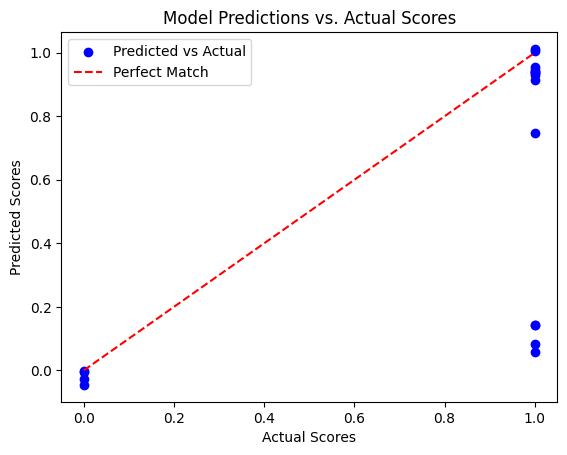

In [10]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [11]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the knee is lifted and the arm is high
def is_knee_lift_arm_high(knee, ankle, shoulder, wrist):
    """
    Determines if the knee is fully lifted and the arm is high during takeoff.
    Conditions:
    - Knee should be significantly above the ankle.
    - Arm (wrist) should be above the shoulder level.
    """
    knee_x, knee_y = knee
    ankle_x, ankle_y = ankle
    shoulder_x, shoulder_y = shoulder
    wrist_x, wrist_y = wrist

    knee_lifted = knee_y < ankle_y - 0.1  # Knee should be higher than ankle
    arm_high = wrist_y < shoulder_y       # Wrist should be higher than shoulder

    return knee_lifted and arm_high

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage3/test_videos/1_user10.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for knee lift and arm high analysis
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x,
                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y]

        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
        right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y]

        # Check for knee lift and arm position for both sides
        left_takeoff = is_knee_lift_arm_high(left_knee, left_ankle, left_shoulder, left_wrist)
        right_takeoff = is_knee_lift_arm_high(right_knee, right_ankle, right_shoulder, right_wrist)

        # Store the binary values (0 or 1) for analysis
        new_keypoints.append([int(left_takeoff), int(right_takeoff)])

cap.release()

# Pad the sequence to match training input length
max_seq_length = X_train.shape[1]  # Ensure it's the same length used during training
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((new_keypoints_padded.shape[0], new_keypoints_padded.shape[1], 2))

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737665614.084719 11090681 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737665614.141297 11165536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737665614.149798 11165536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Predicted Score: 0.93


In [12]:
print(X_train.shape[1])

84


In [19]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.75:
        return 1.0
    elif prediction >= 0.5:
        return 0.5
    else:
        return 0.0

In [20]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 0.5, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 1.0


In [21]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [23]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Classification Accuracy: 0.72


In [24]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/height_jump/stages/stage3/models/highjump_stage3.keras")